In [ ]:
#!pip install duckdb
#!pip install seaborn
#!pip install matplotlib

In [1]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
con = duckdb.connect("../data/silver/pte_personal.duckdb")  

In [7]:
# Read from partitioned parquet files
duckdb.sql("""
    INSTALL 'icu';
    LOAD 'icu';
           
    CREATE OR REPLACE TABLE pte_personal AS
    SELECT 
           year, month, id_entidad,
           IN_PERSONAL_ANNO, IN_PERSONAL_MES, 
           PK_ID_PERSONAL, VC_PERSONAL_RUC_ENTIDAD,
           VC_PERSONAL_REGIMEN_LABORAL,
           md5(
                     lower(
                     regexp_replace(
                     regexp_replace(
                            nfc_normalize(trim(VC_PERSONAL_PATERNO)) || '_' ||
                            nfc_normalize(trim(VC_PERSONAL_MATERNO)) || '_' ||
                            nfc_normalize(trim(VC_PERSONAL_NOMBRES)),
                            '[\u0300-\u036f]', '', 'g'  -- remove accents
                     ),
                     '[^a-zA-Z0-9_]', '', 'g'       -- remove special characters
                     )
                     )
                     ) AS PERSONAL_HASH,
           VC_PERSONAL_PATERNO, VC_PERSONAL_MATERNO, VC_PERSONAL_NOMBRES,
           VC_PERSONAL_CARGO, VC_PERSONAL_DEPENDENCIA,
           MO_PERSONAL_TOTAL, VC_PERSONAL_OBSERVACIONES
    FROM 
            parquet_scan('../data/bronze/**/data.parquet', union_by_name=true, hive_partitioning=true);
""")

In [8]:
# Read from partitioned parquet files
duckdb.sql("""
    CREATE OR REPLACE TABLE grouped_personal AS
    SELECT 
            year, month, id_entidad,
            count(1) as total_rows 
    FROM 
            pte_personal
    GROUP BY 
            year, month, id_entidad
                  ;
""")

In [9]:
# Light transformation: aggregate by entity + year
df_grouped = duckdb.sql("""
    SELECT 
        *
    FROM grouped_personal
    
""").df()

/tmp/ipykernel_598438/63413902.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = df_grouped.pivot(index='id_entidad', columns='period', values='has_data').fillna(False).astype(int)


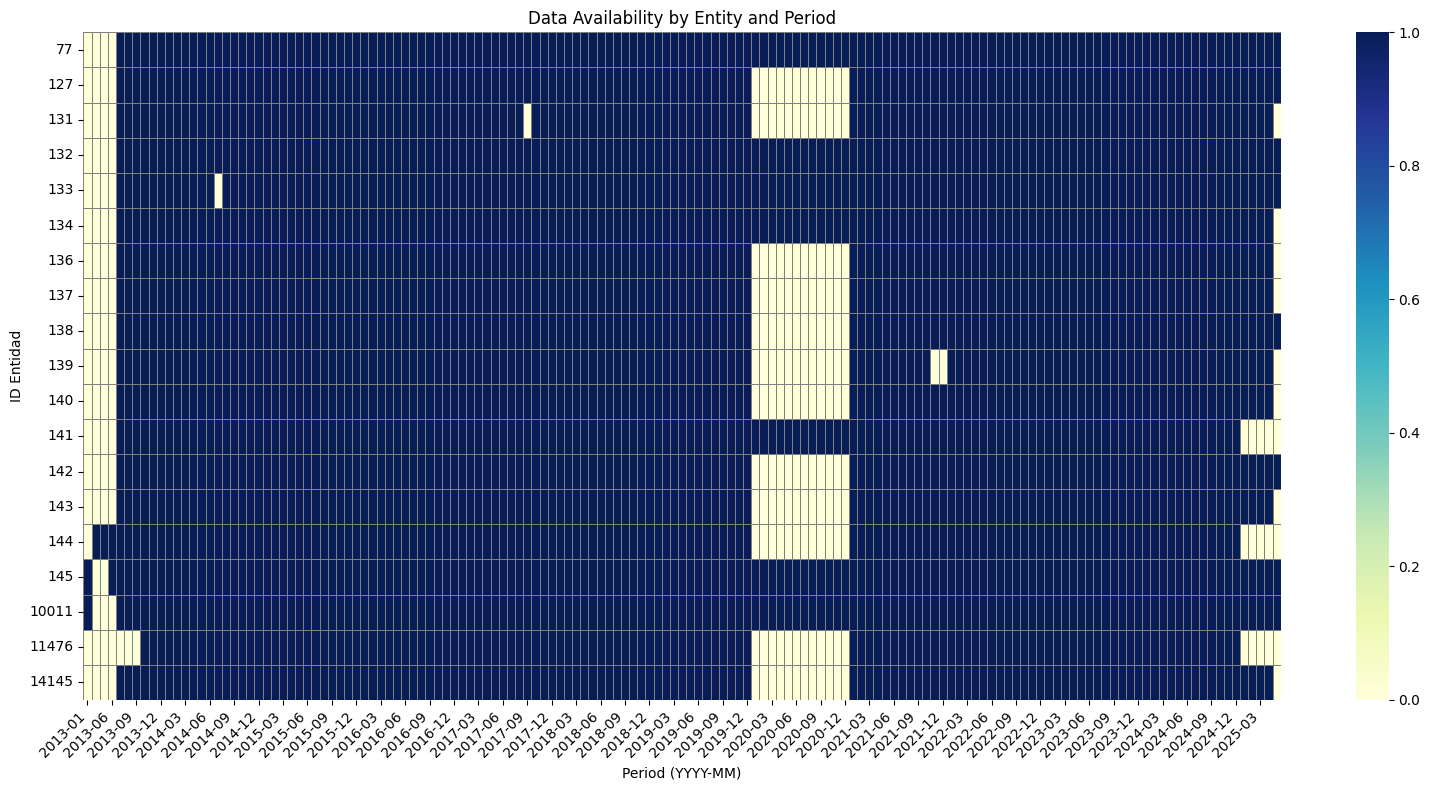

In [10]:
# 1. Create 'period' column in YYYY-MM format
df_grouped['period'] = df_grouped['year'].astype(str) + '-' + df_grouped['month'].astype(str).str.zfill(2)

# 2. Mark whether data exists
df_grouped['has_data'] = df_grouped['total_rows'] > 0

# 3. Pivot to matrix: rows = entities, cols = period
matrix = df_grouped.pivot(index='id_entidad', columns='period', values='has_data').fillna(False).astype(int)

# 4. Plot heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(matrix, cmap='YlGnBu', cbar=True, linewidths=0.5, linecolor='gray')

plt.title('Data Availability by Entity and Period')
plt.xlabel('Period (YYYY-MM)')
plt.ylabel('ID Entidad')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [4]:
df = duckdb.sql("""
    SELECT 
        *
    FROM pte_personal
    
""").df()

In [5]:
df

,year,month,id_entidad,IN_PERSONAL_ANNO,IN_PERSONAL_MES,PK_ID_PERSONAL,VC_PERSONAL_RUC_ENTIDAD,VC_PERSONAL_REGIMEN_LABORAL,PERSONAL_HASH,VC_PERSONAL_PATERNO,VC_PERSONAL_MATERNO,VC_PERSONAL_NOMBRES,VC_PERSONAL_CARGO,VC_PERSONAL_DEPENDENCIA,MO_PERSONAL_TOTAL,VC_PERSONAL_OBSERVACIONES
0,2013,1,10011,2013,1,139273,20131367938,7.0,f10e1b4ceb6fffe8caac43da8f250cad,Galindo,Heredia,José Antonio,Director,Dirección General de Educación y Doctrina,0.0,None
1,2013,1,10011,2013,1,111684,20131367938,7.0,f10e1b4ceb6fffe8caac43da8f250cad,Galindo,Heredia,José Antonio,Director,Dirección General de Educación y Doctrina,0.0,None
2,2013,1,10011,2013,1,111657,20131367938,7.0,f10e1b4ceb6fffe8caac43da8f250cad,Galindo,Heredia,José Antonio,Director General de Educación y Doctrina,Dirección General de Educación y Doctrina,0.0,None
3,2013,1,10011,2013,1,111656,20131367938,7.0,f10e1b4ceb6fffe8caac43da8f250cad,Galindo,Heredia,José Antonio,Director General de Educación y Doctrina,Dirección General de Educación y Doctrina,0.0,None
4,2013,1,10011,2013,1,111655,20131367938,7.0,f10e1b4ceb6fffe8caac43da8f250cad,Galindo,Heredia,José Antonio,Director General de Educación y Doctrina,Dirección General de Educación y Doctrina,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8273907,2024,9,77,2024,9,77120842,20537630222,5.0,5ff57fa6fc2ada3d9f2dc0a9b4139da3,VADILLO,VILA,JOSÉ ANTONIO,CONSULTOR FAG,GABINETE DE ASESORES,15600.0,None
8273908,2024,9,77,2024,9,77120843,20537630222,5.0,e01ff4bc5bb72481b083675603df835f,ZAPATA,DE LA ROSA,RICARDO CRISTOPHER,CONSULTOR FAG,SECRETARÍA GENERAL,13000.0,None
8273909,2024,9,77,2024,9,77120844,20537630222,5.0,09b0023ef0edb93d2d7804da9bc28a20,ARANA,ÑIQUE,HERNAN ALFONSO,CONSULTOR FAG,DESPACHO VICEMINISTERIAL DE PATRIONIO CULTURAL...,15000.0,None
8273910,2024,9,77,2024,9,77120845,20537630222,5.0,5375e14f1186208058552539d26a4b96,SOLARI,DIAZ,JESÚS ANTONIO,CONSULTOR FAG,DESPACHO MINITERIAL,15600.0,None


In [6]:
df.columns

Index(['year', 'month', 'id_entidad', 'IN_PERSONAL_ANNO', 'IN_PERSONAL_MES',
       'PK_ID_PERSONAL', 'VC_PERSONAL_RUC_ENTIDAD',
       'VC_PERSONAL_REGIMEN_LABORAL', 'PERSONAL_HASH', 'VC_PERSONAL_PATERNO',
       'VC_PERSONAL_MATERNO', 'VC_PERSONAL_NOMBRES', 'VC_PERSONAL_CARGO',
       'VC_PERSONAL_DEPENDENCIA', 'MO_PERSONAL_TOTAL',
       'VC_PERSONAL_OBSERVACIONES'],
      dtype='object')